In [1]:
import pandas as pd
import joblib
df = pd.read_csv("/Users/ryanghosh/Documents/Python <:>/phishing_email_detection_website/Phishing_Email.csv", dtype="str")
df2 = pd.read_csv("/Users/ryanghosh/Documents/Python <:>/phishing_email_detection_website/Enron.csv", dtype="str")

In [2]:
x=df["Email Text"].fillna("")
y=df["Email Type"]
mask = (x.str.len() > 0) & (y.notna())
x = x[mask]
y = y[mask]
print(df.shape)

(18650, 3)


In [5]:
df = pd.read_csv("/Users/ryanghosh/Documents/Python <:>/phishing_email_detection_website/Phishing_Email.csv", dtype="str")
df2 = pd.read_csv("/Users/ryanghosh/Documents/Python <:>/phishing_email_detection_website/Enron.csv", dtype="str")

print("Phishing_Email.csv shape:", df.shape)
print("Enron.csv shape:", df2.shape)

Phishing_Email.csv shape: (18650, 3)
Enron.csv shape: (29767, 3)


In [3]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [4]:
df2["subject"] = df2["subject"].fillna("")
df2["body"] = df2["body"].fillna("")

df2["text"] = df2["subject"] + " " + df2["body"]

x2 = df2["text"]
y2 = df2["label"]

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x2, y2, test_size=0.3, random_state=42
)

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=5000)),
    ('classifier', LinearSVC())
])

svm_pipeline.fit(x_train, y_train)
preds = svm_pipeline.predict(x_test)
acc = accuracy_score(y_test, preds)

print("=== Results on first split (20% test) ===")
print(f"SVM Accuracy: {acc:.3f}")
print(classification_report(y_test, preds))

x2_train, x2_test, y2_train, y2_test = train_test_split(
    x2, y2, test_size=0.3, random_state=42
)

svm_pipeline.fit(x2_train, y2_train)
preds2 = svm_pipeline.predict(x2_test)
acc2 = accuracy_score(y2_test, preds2)

print("\n=== Results on second split (30% test) ===")
print(f"SVM Accuracy: {acc2:.3f}")
print(classification_report(y2_test, preds2))

joblib.dump(svm_pipeline, "svm_model.pkl")
print("saved as svm_model.pkl")


=== Results on first split (20% test) ===
SVM Accuracy: 0.988
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4762
           1       0.98      0.99      0.99      4169

    accuracy                           0.99      8931
   macro avg       0.99      0.99      0.99      8931
weighted avg       0.99      0.99      0.99      8931


=== Results on second split (30% test) ===
SVM Accuracy: 0.988
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4762
           1       0.98      0.99      0.99      4169

    accuracy                           0.99      8931
   macro avg       0.99      0.99      0.99      8931
weighted avg       0.99      0.99      0.99      8931

saved as svm_model.pkl


In [6]:
import openai
openai.api_key = ""

def gpt_threat_analysis(email_text, prediction, confidence):
    prompt = f"""
    You are a cybersecurity assistant.

    An email has been classified by an ML phishing detector.

    Email content:
    {email_text}

    ML Prediction: {prediction} (confidence: {confidence:.2f})

    Provide:
    1. THREAT LEVEL: Low / Medium / High.
    2. Explanation of the potential RISKS if the user interacted with this email.
    3. Advice: Should the user BLOCK this sender or mark as safe?
    """

    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "system", "content": "You are a cybersecurity assistant."},
                  {"role": "user", "content": prompt}],
        max_tokens=300,
        temperature=0.3
    )

    return response["choices"][0]["message"]["content"]


In [7]:
label_map = {
    '0': "safe",
    '1': "phishing"
}

In [11]:
!pip3 install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 16.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.0/274.0 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 18.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 18.4 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip3 install --upgrade pip


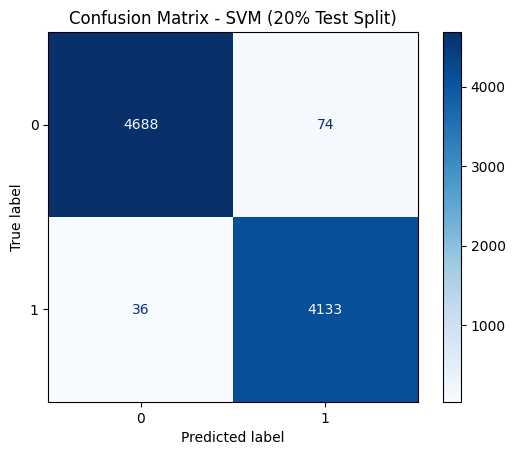

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predictions (you already have preds)
preds = svm_pipeline.predict(x_test)

# Create confusion matrix
cm = confusion_matrix(y_test, preds, labels=svm_pipeline.classes_)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_pipeline.classes_)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - SVM (20% Test Split)")
plt.show()


In [14]:
!pip3 install openai==0.28

  Using cached openai-0.28.0-py3-none-any.whl.metadata (13 kB)
Using cached openai-0.28.0-py3-none-any.whl (76 kB)

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip3 install --upgrade pip


In [16]:
for i, email in enumerate(x_test[:5]):  
    prediction = preds[i]              # '0' or '1'
    human_label = label_map[prediction]

    print(f"\nEmail: {email[:200]}...")
    print(f"SVM Prediction: {human_label}")

    if human_label == "phishing":
        gpt_response = gpt_threat_analysis(email, human_label, acc)
        print("Analysis:\n", gpt_response)
    else:
        print("Safe email. No analysis needed.")



Email: karthik rajan - interview schedule attached you will find the interview packet for the above - referenced person .
the interview will happen friday , march 30 , 2001 . please print all three
documen...
SVM Prediction: safe
Safe email. No analysis needed.

Email: re : a 3 al ad hoc review team in the week of the 25 th . , the 26 th and 27 th are fine , with the 27 th being
the best .
thanks , john
- - - - - original message - - - - -
from : holden - baker ...
SVM Prediction: safe
Safe email. No analysis needed.

Email: not for sale in the u . a . e - usb voip handset w / built in audio adapter not for sale in the u . a . e
usb voip handset w / built in audio adapter
$ 25 . 00
enjoy
stereo music or make internet ...
SVM Prediction: phishing


APIRemovedInV1: 

You tried to access openai.ChatCompletion, but this is no longer supported in openai>=1.0.0 - see the README at https://github.com/openai/openai-python for the API.

You can run `openai migrate` to automatically upgrade your codebase to use the 1.0.0 interface. 

Alternatively, you can pin your installation to the old version, e.g. `pip install openai==0.28`

A detailed migration guide is available here: https://github.com/openai/openai-python/discussions/742
